# Revenue Prediction of Online Shoppers

## Introduction

Online shopping has rapidly advanced in recent years, with vast arrays of data documenting online shopper behaviour becoming accessible for advertising and analytics.

This project aims to provide a classification model which will predict whether a potential online shopper will make a purchase during a given session based on the page value (the value of a page for revenue, generated by Google Analytics (Google Analytics, 2021), the bounce rate (percentage of users that enter the web page during that session and then leave (2021)) and the exit rate (percentage of users that exit the session after viewing that page (2021)). 

This study uses a dataset from The Online Shoppers Purchasing Intention Dataset on the UCI Machine Learning Repository, which documents the online shopping sessions of 12330 different users over one year (Sakar & Kastro, 2018).

# Methods and Results

This investigation used the variables PageValues, ExitRate and BounceRate as the predictors, and Revenue as the target.

These three predictors were chosen because in real life, how a user interacts with a site, as seen through bounce and exit rates can indicate purchases being made, and it was predicted the data reflects this. Furthermore, the page’s value for revenue also plays a role in how likely purchases are made on it, thus page value is expected to also predict Revenue accurately. No other categorical variables, such as Browser, were chosen due to weighing difficulties for categorical predictors in K-nn classification (Faisal & Tutz, 2017).

The K-nearest neighbour model was used to predict if an online shopper would make a purchase during a given session. Cross-validation and tuning was used to pick the K-value that maximizes validation accuracy. The model predicted revenue based on the testing set, with the prediction accuracy being determined and the results displayed in a confusion matrix. A scatterplot for the testing set was not made due to three predictors being used and the visualization difficulties involved.

## Data Preparation

In [1]:
# Loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
require(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Loading datasets
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
download.file(url, "online_shoppers_intention.csv")
shopping_data <- read_csv("online_shoppers_intention.csv")

Parsed with column specification:
cols(
  Administrative = col_double(),
  Administrative_Duration = col_double(),
  Informational = col_double(),
  Informational_Duration = col_double(),
  ProductRelated = col_double(),
  ProductRelated_Duration = col_double(),
  BounceRates = col_double(),
  ExitRates = col_double(),
  PageValues = col_double(),
  SpecialDay = col_double(),
  Month = col_character(),
  OperatingSystems = col_double(),
  Browser = col_double(),
  Region = col_double(),
  TrafficType = col_double(),
  VisitorType = col_character(),
  Weekend = col_logical(),
  Revenue = col_logical()
)



In [3]:
# Clean data 
options(repr.matrix.max.rows = 6)
set.seed(1234)

data <- shopping_data %>% 
        select(PageValues, BounceRates, ExitRates, Revenue) %>%
        mutate(Revenue = as_factor(Revenue)) 

To clean the data, the predictors and classifiers were selected, removing variables not being used in creating the model. Revenue was then converted to a factor for predictive purposes because it is a categorical statistical variable.

In [4]:
# Split data into training and testing datasets
data_split <- initial_split(data, prop = 0.75, strata = Revenue)
data_training <- training(data_split)
data_testing <- testing(data_split)

The data was split into training and testing sets. 75% of the data was chosen for the training set, allowing for the model to be trained solely on this data portion, with the unseen 25% used to determine the model’s accuracy. As the dataset had 12330 items, 25% was determined to be a sufficient amount of data to successfully test the predictive model. 75% was allocated for training to increase the amount of data the model could learn from.

## Preliminary Exploration

In [5]:
# Check if there are any rows with missing data
print("Table 1: Number of Rows with Missing Data for the Predictor and Classifier Variables")
empty_count <- map_df(data_training, ~sum(is.na(.)))
empty_count

[1] "Table 1: Number of Rows with Missing Data for the Predictor and Classifier Variables"


PageValues,BounceRates,ExitRates,Revenue
<int>,<int>,<int>,<int>
0,0,0,0


The number of rows with missing data points was determined to decide whether the data should be filtered further and to check if the predictors chosen have enough data. No values were missing (Table 1).

In [6]:
# Calculate number of observations for Revenue 
counts <- count(data_training, Revenue)
noRevenueCount <- filter(counts, Revenue == FALSE) %>% select(n) %>% pull()
yesRevenueCount <- filter(counts, Revenue == TRUE) %>% select(n) %>% pull()

# Put revenue data into table
revenue_count <- matrix(c(yesRevenueCount, noRevenueCount), ncol = 2, byrow = TRUE)
colnames(revenue_count) <- c("Revenue", "No Revenue")
rownames(revenue_count) <- c("Number of Sessions")
print("Table 2: Number of Sessions that Ended with a Purchase (Revenue) or No Purchase (No Revenue)")
revenue_count

[1] "Table 2: Number of Sessions that Ended with a Purchase (Revenue) or No Purchase (No Revenue)"


,Revenue,No Revenue
Number of Sessions,1431,7817


The data was not significantly unbalanced between items classified as revenue and no revenue (Table 2), thus indicating upsampling the data was unnecessary. Furthermore, the combination of upsampling and crossfold validation introduced unnecessary complexity and potential error.

In [7]:
# Calculate mean values of predictor variables and class revenue
data_mean <- data_training %>%
    select(-Revenue) %>%
    map_df(mean) 

# Calculate median value of predictor variables 
data_median <- data_training %>%
    select(-Revenue) %>%
    map_df(median) 

# Create table for mean and median values of predictor variables 
mean_median_table <- rbind(data_mean, data_median)
Statistics <- c("Mean", "Median")
mean_median_table <- cbind(Statistics, mean_median_table)
print("Table 3: Mean and Median Values of the Predictor and Classifier Variables")
mean_median_table

[1] "Table 3: Mean and Median Values of the Predictor and Classifier Variables"


Statistics,PageValues,BounceRates,ExitRates
<chr>,<dbl>,<dbl>,<dbl>
Mean,5.923297,0.021995910,0.04281168
Median,0.000000,0.003076923,0.02500000


The mean and median were found to gain insight into predictor distribution and to check if the data was skewed. At least half of the pages had a page value of zero as the median was zero.

In [8]:
pages <- count(data_training %>% filter(PageValues == 0)) %>% pull()
total_pages <- count(data_training) %>% pull()
print(paste("There are", pages, "pages with a page value of 0 out of a total of", total_pages, "pages"))

[1] "There are 7183 pages with a page value of 0 out of a total of 9248 pages"


To investigate PageValues’ median of zero, the total number of sessions with zero page value were calculated, with the majority of the sessions being found to have page values 0.

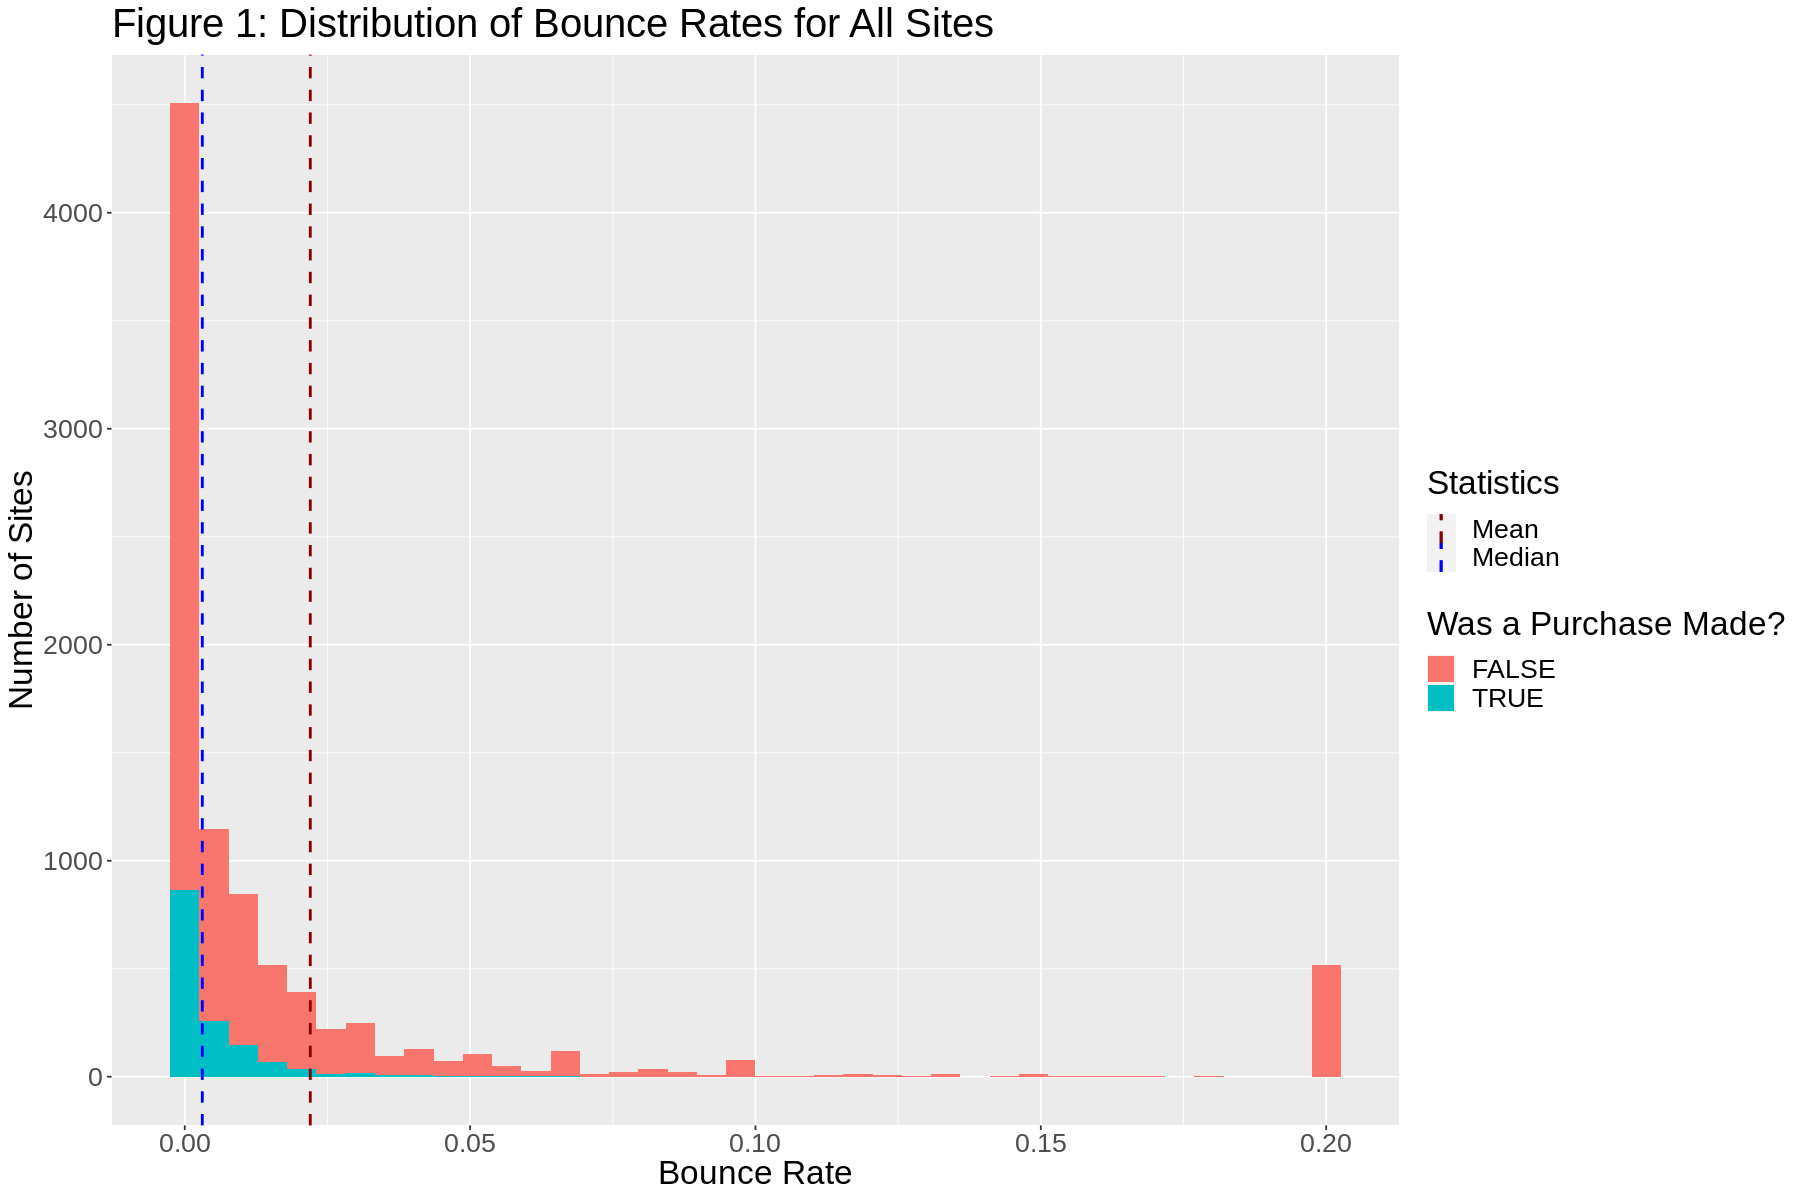

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10) 

bounceRates_dist <- ggplot(data_training, aes(x = BounceRates, fill = Revenue)) + 
                    geom_histogram(bins = 40) + 
                    geom_vline(aes(xintercept=mean(BounceRates), color = "Mean"), linetype="dashed", size=0.8) + 
                    geom_vline(aes(xintercept=median(BounceRates), color = "Median"), linetype="dashed", size=0.8) +
                    labs(x = "Bounce Rate", y = "Number of Sites", title = "Figure 1: Distribution of Bounce Rates for All Sites", fill = "Was a Purchase Made?") + 
                    theme(text = element_text(size = 20)) +
                    scale_color_manual(name = "Statistics", values = c(Median = "blue", Mean = "darkred"))


bounceRates_dist

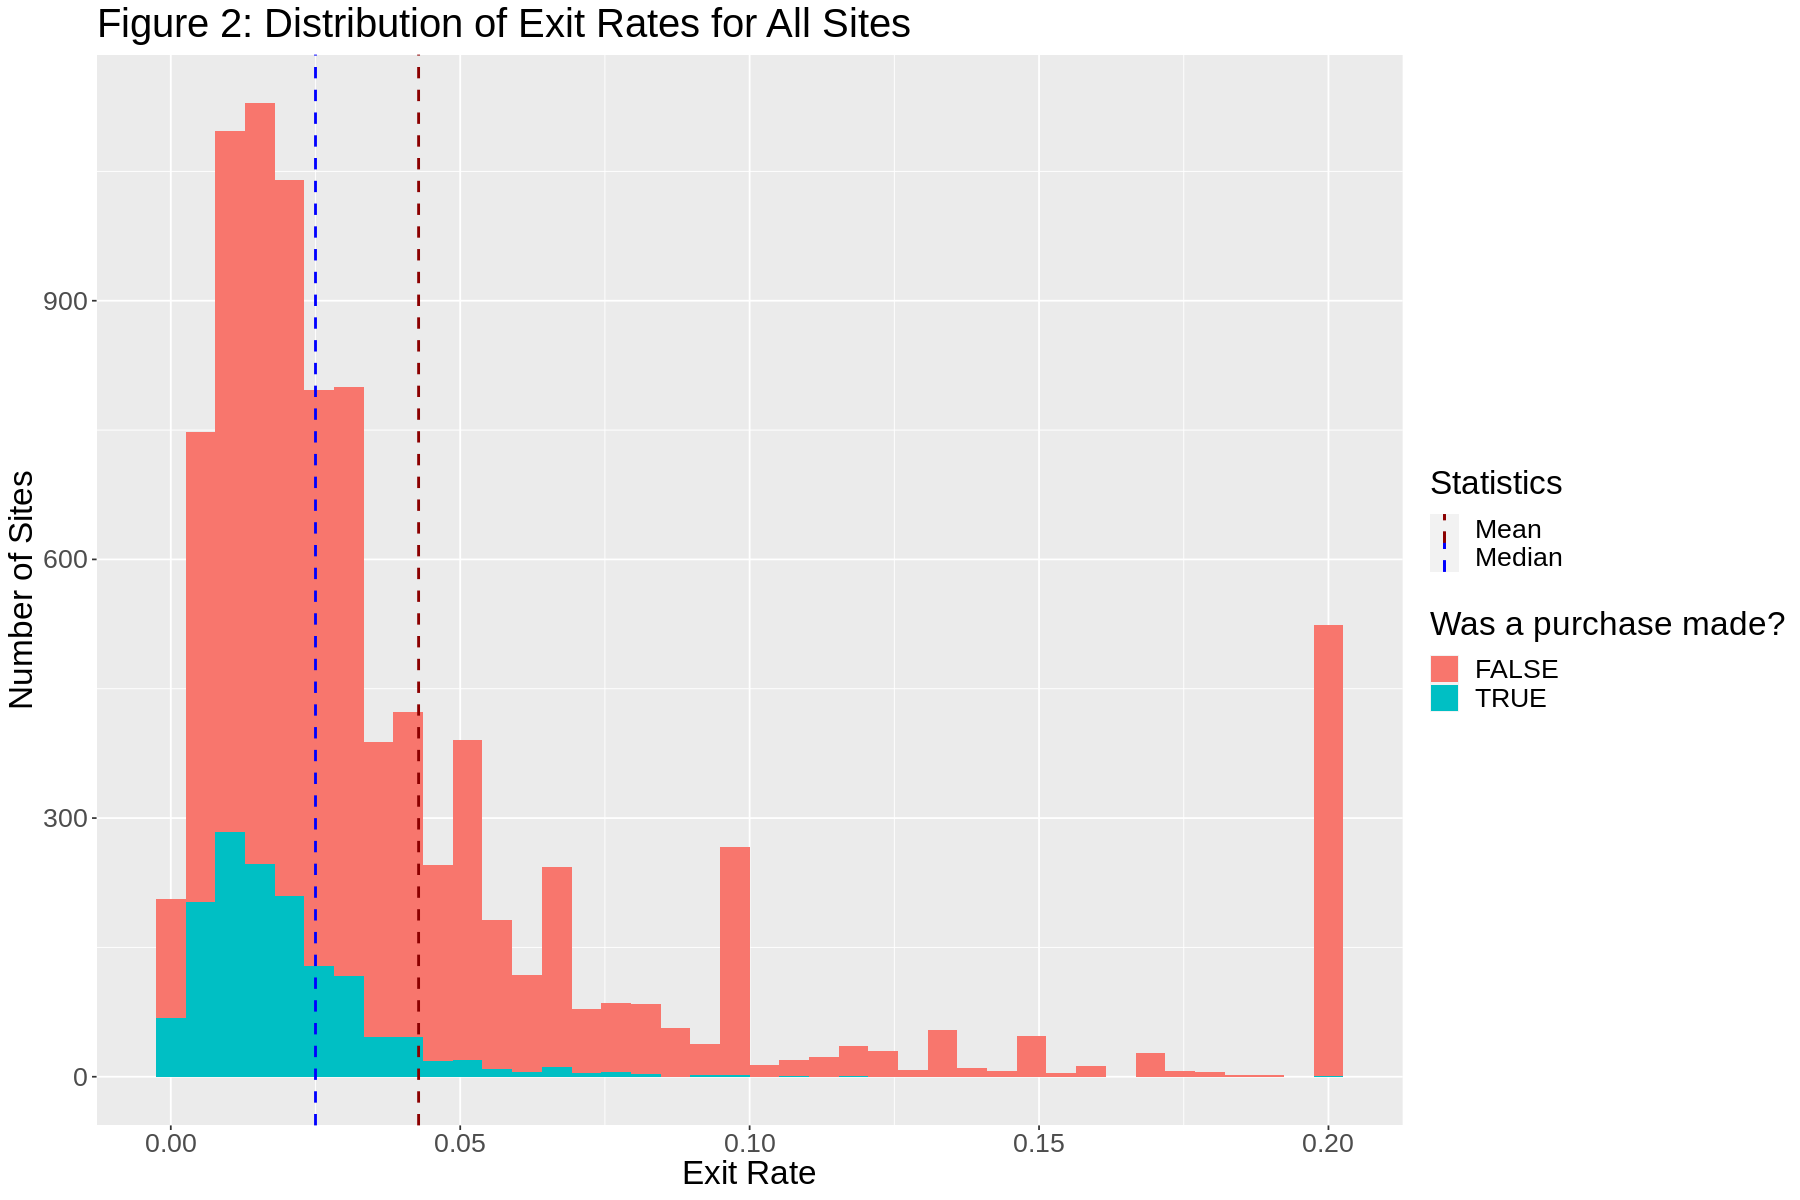

In [10]:
exitRates_dist <- ggplot(data_training, aes(x = ExitRates, fill = Revenue)) + 
                  geom_histogram(bins=40) + 
                  geom_vline(aes(xintercept=mean(ExitRates), color = "Mean"), linetype="dashed", size=0.8) + 
                  geom_vline(aes(xintercept=median(ExitRates), color = "Median"), linetype="dashed", size=0.8) +
                  labs(x = "Exit Rate", y = "Number of Sites", title = "Figure 2: Distribution of Exit Rates for All Sites", fill = "Was a purchase made?") + 
                  theme(text = element_text(size = 20)) +
                  scale_color_manual(name = "Statistics", values = c(Median = "blue", Mean = "darkred"))

exitRates_dist

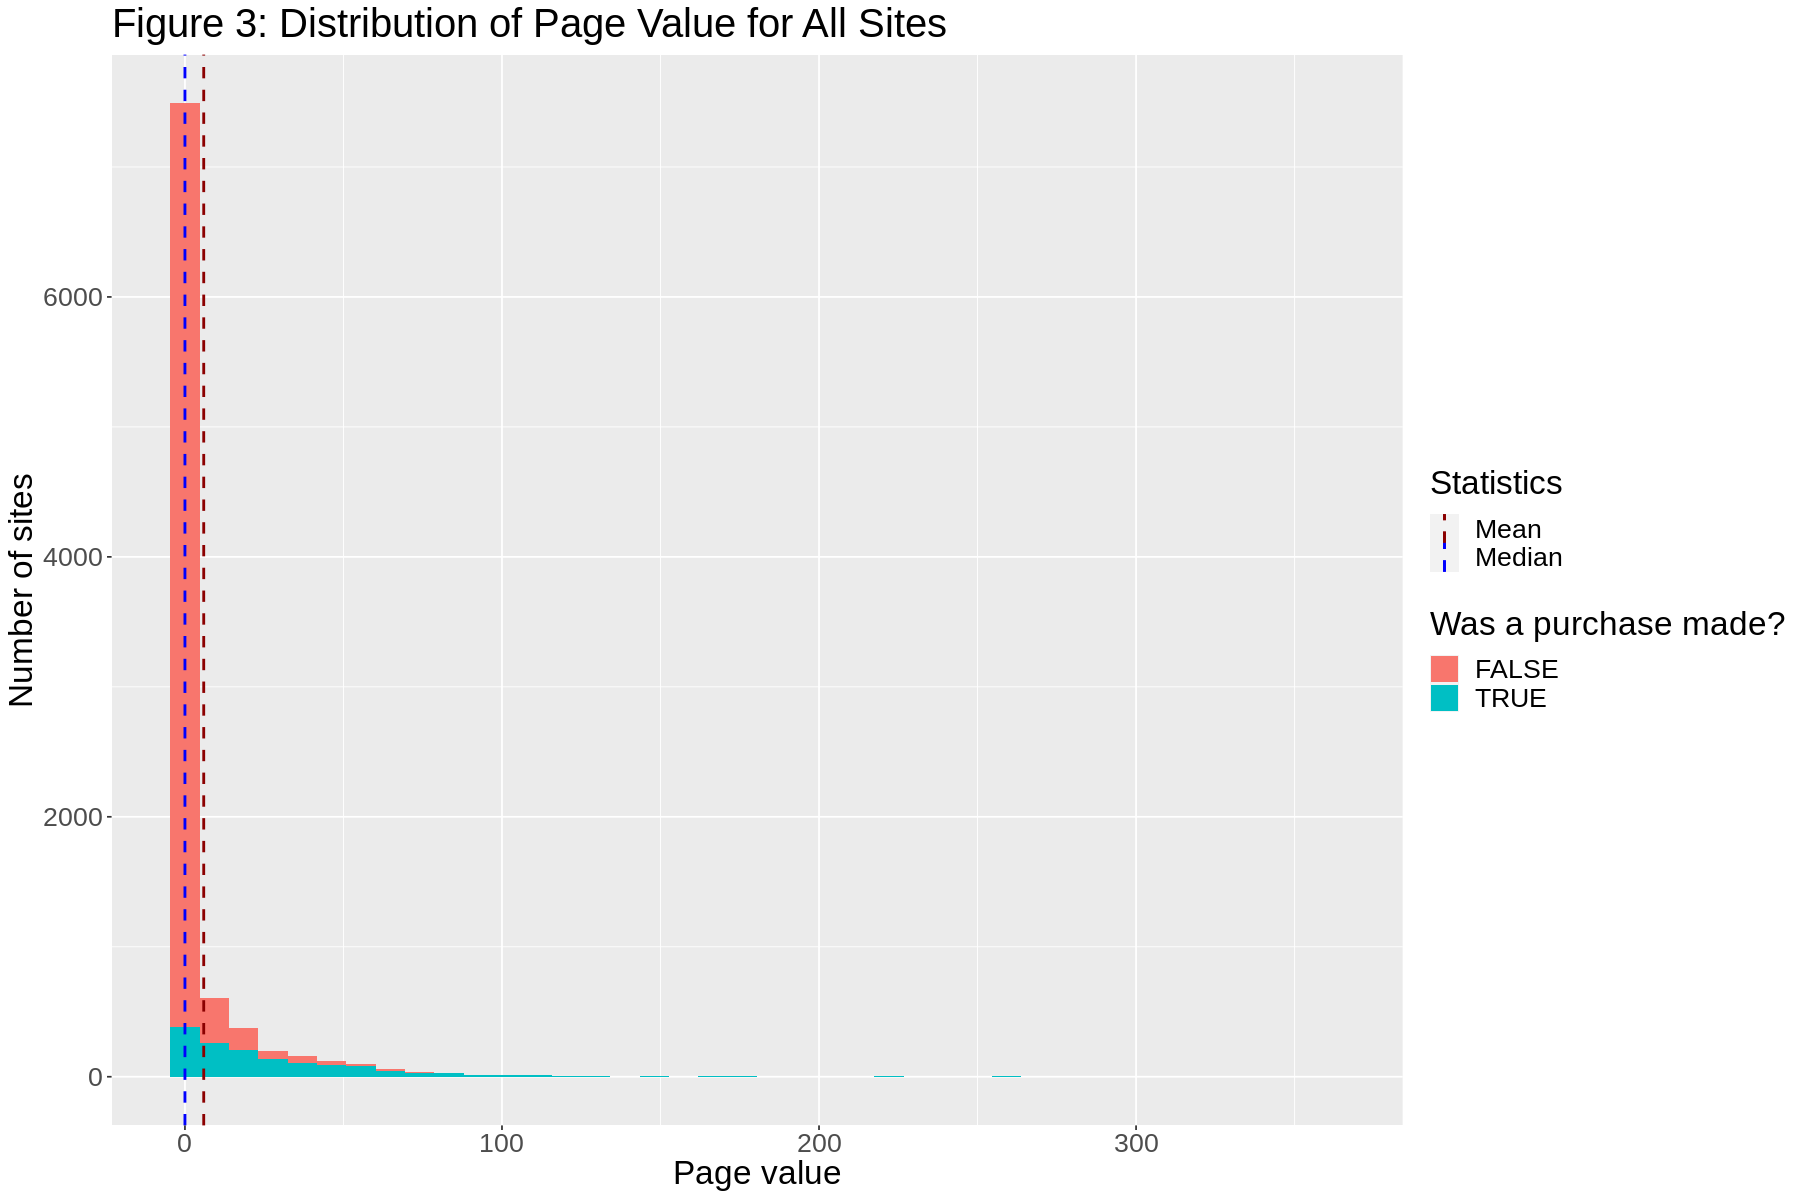

In [11]:
pageval_dist <- ggplot(data_training, aes(x = PageValues, fill = Revenue)) + 
             geom_histogram(bins=40) + 
             geom_vline(aes(xintercept=mean(PageValues), color = "Mean"), linetype="dashed", size=0.8) + 
             geom_vline(aes(xintercept=median(PageValues), color = "Median"), linetype="dashed", size=0.8) + 
             labs(x = "Page value", y = "Number of sites", title = "Figure 3: Distribution of Page Value for All Sites", fill = "Was a purchase made?") + 
             theme(text = element_text(size = 20)) +
             scale_color_manual(name = "Statistics", values = c(Median = "blue", Mean = "darkred"))

pageval_dist

The mean value was always greater than median (Figures 1, 2 and 3), indicating most predictor observations were on the low end, but there are some sessions with higher predictor values, such as the 20% exit rate (Figure 2), which increased the mean. TRUE and FALSE revenues usually had similar distributions, although higher page values were solely TRUE revenue values.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



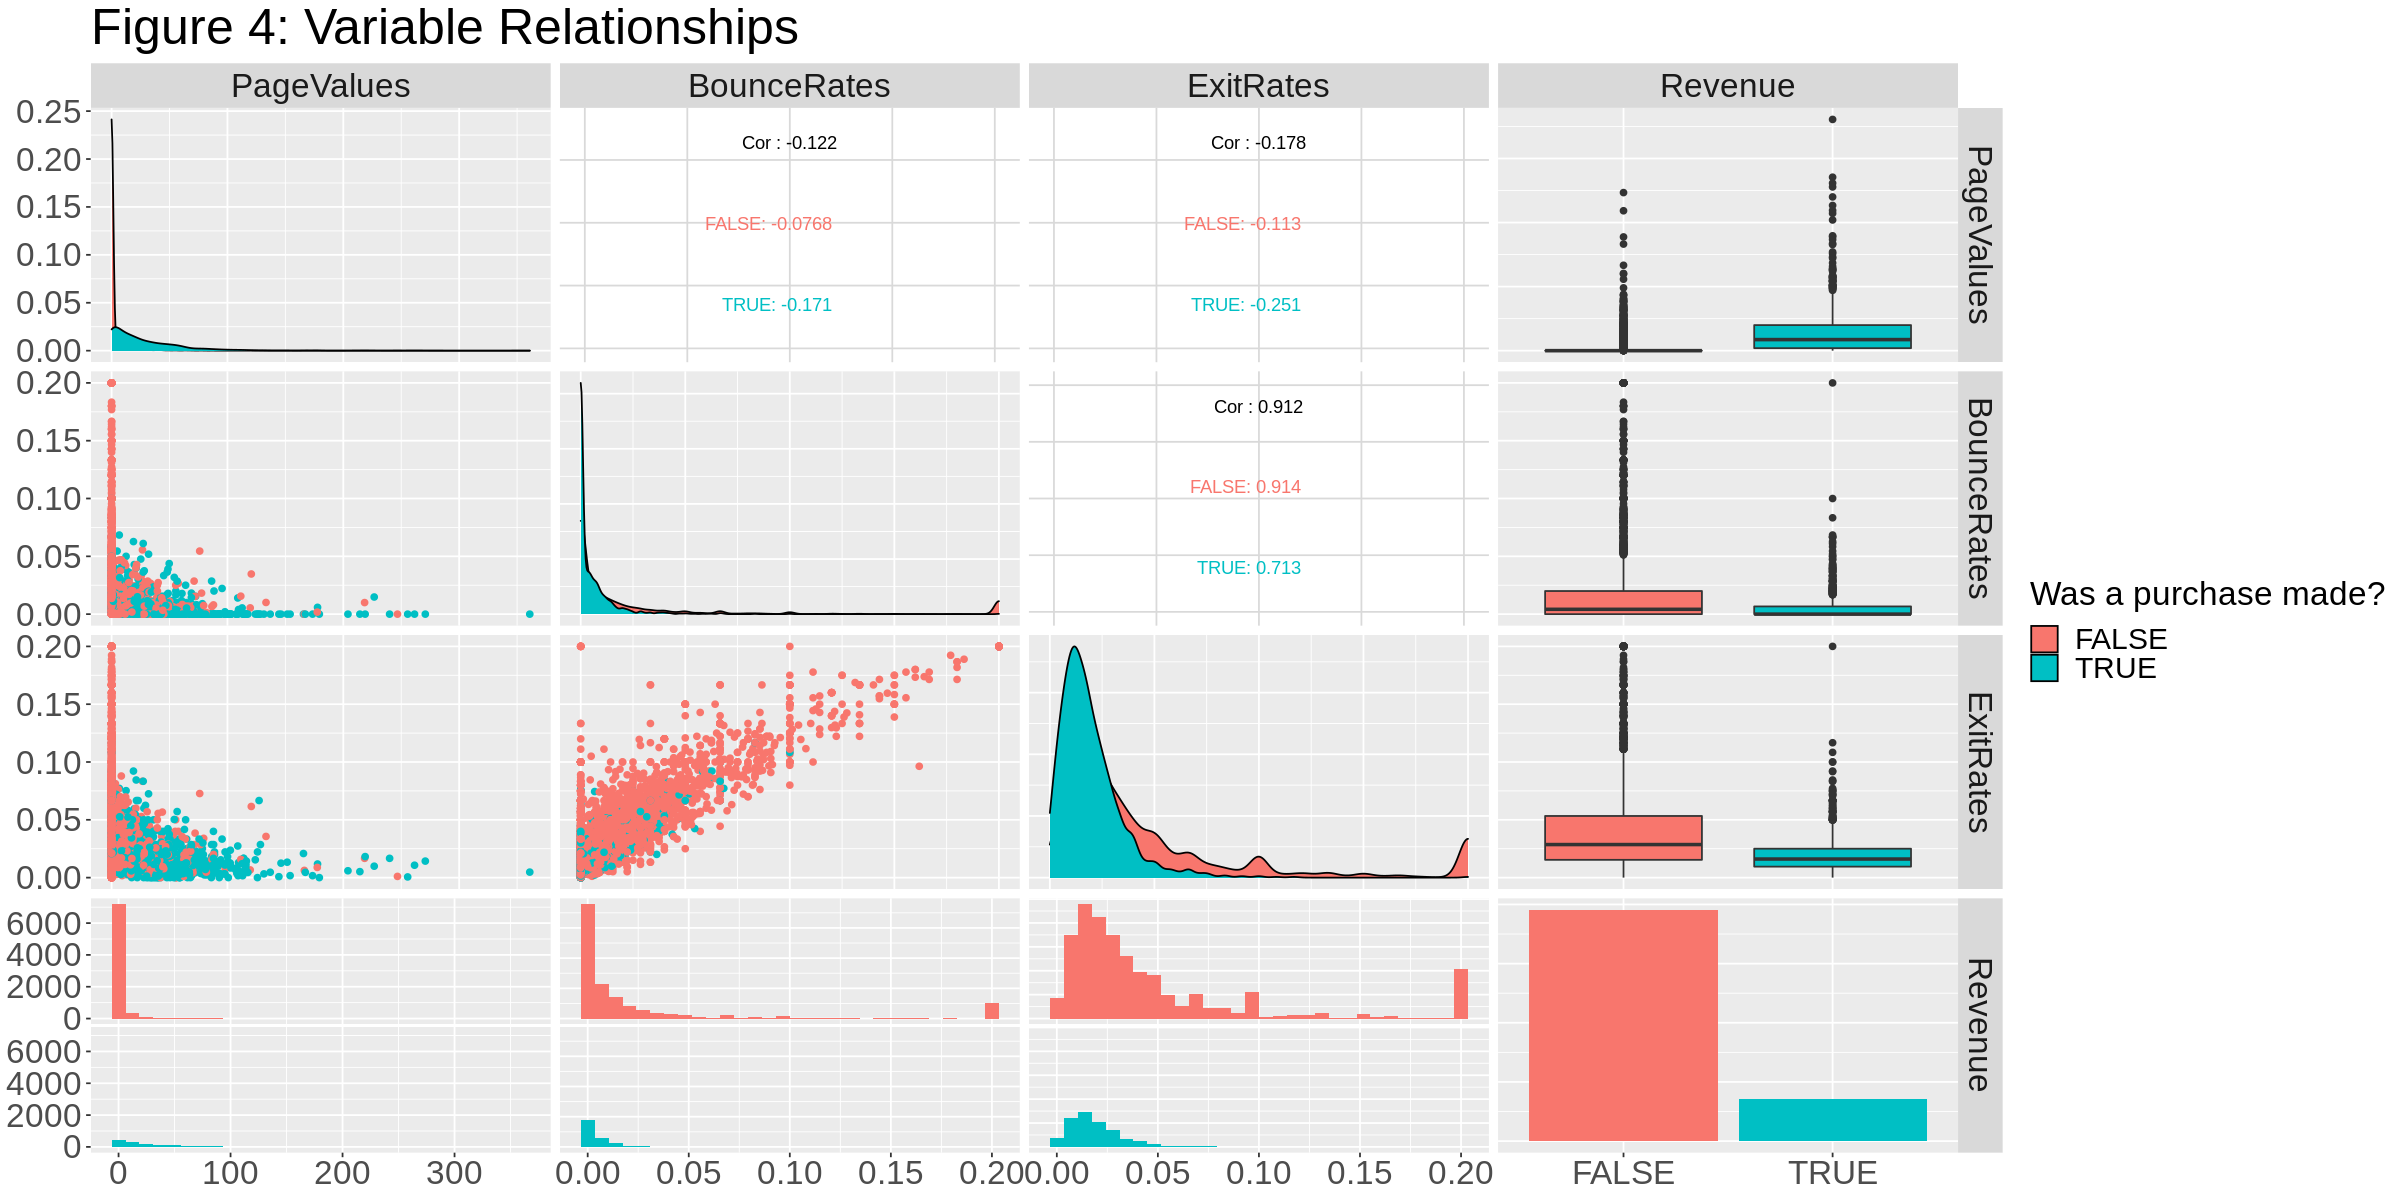

In [12]:
# Relationship between bounce and exit rates
options(repr.plot.width = 20, repr.plot.height = 10) 

relationship_plot <- data_training %>% ggpairs(legend = 1, aes(color = Revenue)) +
                        labs(fill = "Was a purchase made?", title = "Figure 4: Variable Relationships") + 
                        theme(text = element_text(size = 25), legend.title = element_text(size=20), legend.text = element_text(size=18))
relationship_plot

ggpairs was used to examine the relationship between all the variables (Figure 4). Exit and bounce rates had a correlation of 0.912, indicating higher bounce rate pages also have higher exit rates. Exit rate over page value and bounce rate over page value both have negative correlations (-0.178 and -0.122), with TRUE revenue more likely to have higher page values and lower exit and bounce rates than FALSE revenue values.

## Predictive Analysis

In [13]:
# Setting up recipe
recipe <- recipe(Revenue ~ BounceRates + ExitRates + PageValues, data = data_training) %>%
                step_center(all_predictors()) %>%
                step_scale(all_predictors()) 

In the recipe, revenue was specified as the target variable and the variables BounceRates, ExitRates and PageValues were the predictors. The predictors were scaled and centered so their mean was zero with a standard deviation of one.

In [14]:
# We want to do cross validation - talk about this in methods! 
data_vfold <- vfold_cv(data_training, v = 5, strata = Revenue)

In K-nearest neighbours classification, cross-validation helps in picking the K-value that maximizes prediction accuracy. Five fold cross-validation helped tune the model, randomly split the training data into four evenly sized subsets. Four subsets form a training set, while the remaining subset was used for validation. This process was repeated five times; all were used to evaluate the model, calculating each specified K-value’s accuracy and thus determining the most accurate K-value on the validation sets.


In [15]:
# Tune knn model and fit to workflow
model_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#create data frame with K = [5, 10, 15, ... 100]
gridvals <- tibble(neighbors = seq(from = 5, to = 100, by = 5))
print("Table 4: Neighbors Used for Tuning the Model")
gridvals

[1] "Table 4: Neighbors Used for Tuning the Model"


neighbors
<dbl>
5
10
15
⋮
90
95
100


A model specification was created, specifying this model was for K-nn classification and setting neighbours to tune(), allowing multiple K values to be tested instead of a singular one. Every fifth value of K was tested until 100, providing a large range of K-values and thus determining general trends in K accuracy. Using every fifth value reduced the required computation time for testing this large K-value range.

In [16]:
tuning_results <- workflow() %>% 
                    add_recipe(recipe) %>% 
                    add_model(model_tuning) %>% 
                    tune_grid(resamples = data_vfold, grid = gridvals) %>% 
                    collect_metrics() 

A workflow combined the recipe, model specification, tuning and collection of metrics. The tune_grid function determined accuracies and other values from the parameters specified above, with the collect_metrics function aggregating these values. The mean was the estimated accuracy while the standard error was a measure of uncertainty around the mean.

[1] "Table 5: Accuracy Metrics Arranged by Descending Accuracy for Various K-Values"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
95,accuracy,binary,0.8958677,5,0.002858814,Model19
85,accuracy,binary,0.8953269,5,0.002782239,Model17
80,accuracy,binary,0.8952190,5,0.002502677,Model16
⋮,⋮,⋮,⋮,⋮,⋮,⋮
20,accuracy,binary,0.8894861,5,0.004155901,Model04
10,accuracy,binary,0.8861354,5,0.002884501,Model02
5,accuracy,binary,0.8858115,5,0.003309387,Model01


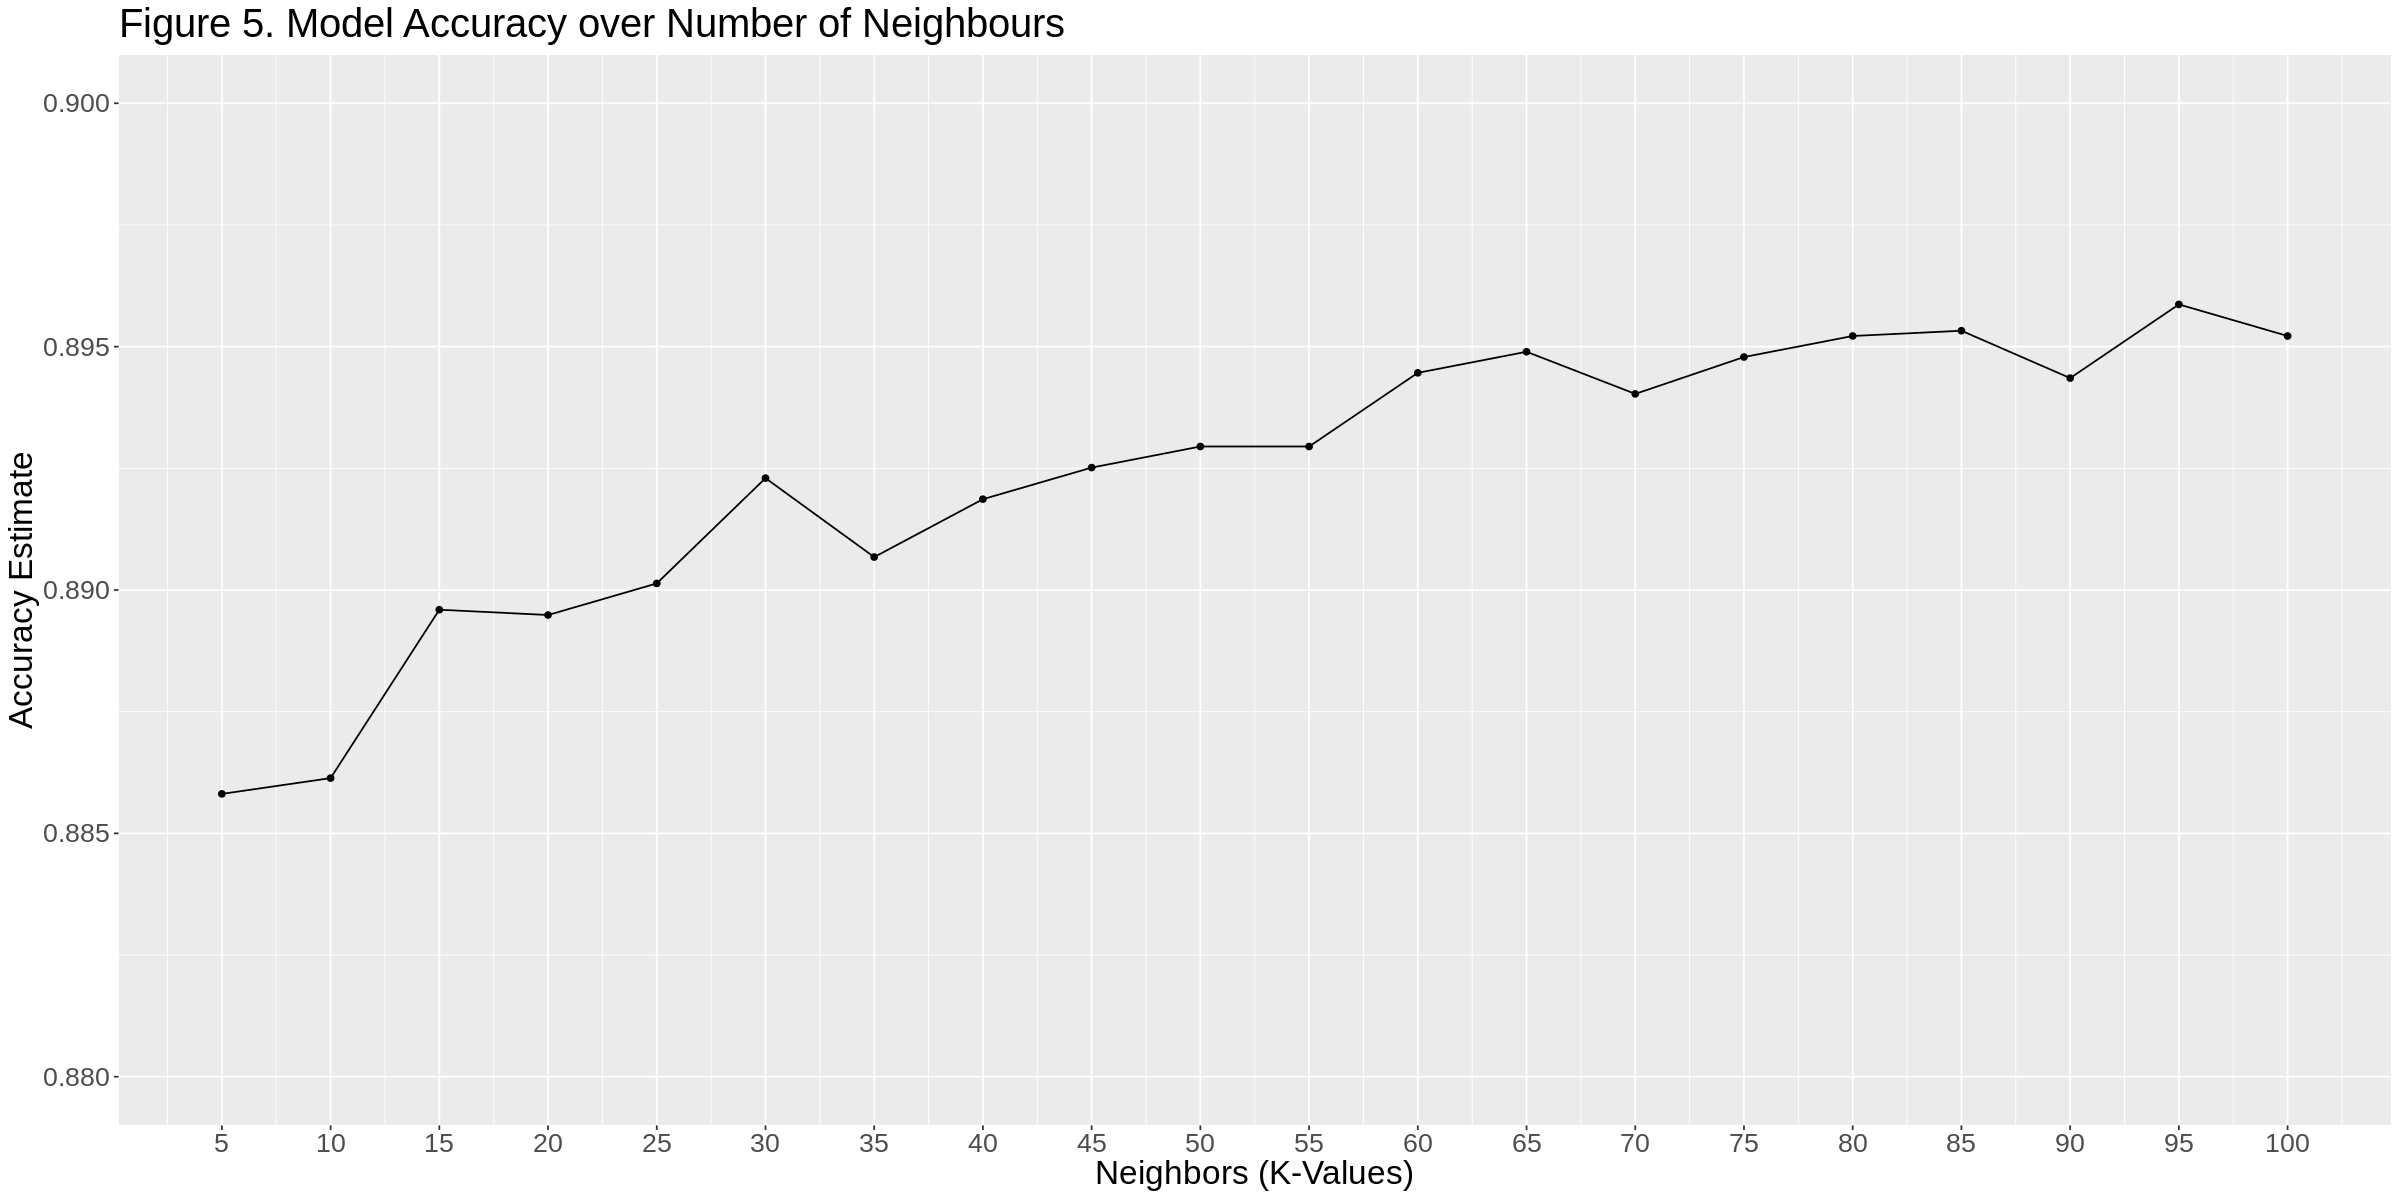

In [17]:
# Creating a plot for accuracy vs. number of neighbours

accuracies <- tuning_results %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
print("Table 5: Accuracy Metrics Arranged by Descending Accuracy for Various K-Values")
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K-Values)", y = "Accuracy Estimate", title = "Figure 5. Model Accuracy over Number of Neighbours") +
    scale_x_continuous(breaks = seq(0, 100, by = 5)) +  
    scale_y_continuous(limits = c(0.88, 0.90)) +
    theme(text = element_text(size = 20))
accuracy_versus_k

To visualize K-value accuracy variation from the training set and cross validation, the K-value range was graphed (Figure 5). Accuracy tended to generally increase as K-values increased, with a peak at 95, however the accuracy variation was very small.

In [18]:
# Tune the best k more
best_k_interval <- tuning_results %>% 
            filter(.metric == "accuracy") %>%
            arrange(desc(mean)) %>%
            select(neighbors) %>%
            head(1) %>%
            pull()
lower_k <- best_k_interval-5
upper_k <- best_k_interval+5

print(paste("Best interval of k values is between", lower_k, "and", upper_k))
best_k_grid <- tibble(neighbors = lower_k:upper_k) %>% filter(neighbors > 0)

[1] "Best interval of k values is between 90 and 100"


The best K-value gave the highest classifier accuracy estimate across all folds. By filtering for accuracy, arranging the mean values in descending order and selecting neighbors, the best K-value was determined. The K-values in an interval of 10 [k-5 : k+5] around the determined best K-value were then tested to see if values close by were more accurate as only every fifth number from 5 to 100 was initially tested.

In [19]:
tuning_results_best <- workflow() %>% 
                    add_recipe(recipe) %>% 
                    add_model(model_tuning) %>% 
                    tune_grid(resamples = data_vfold, grid = best_k_grid) %>% 
                    collect_metrics() 

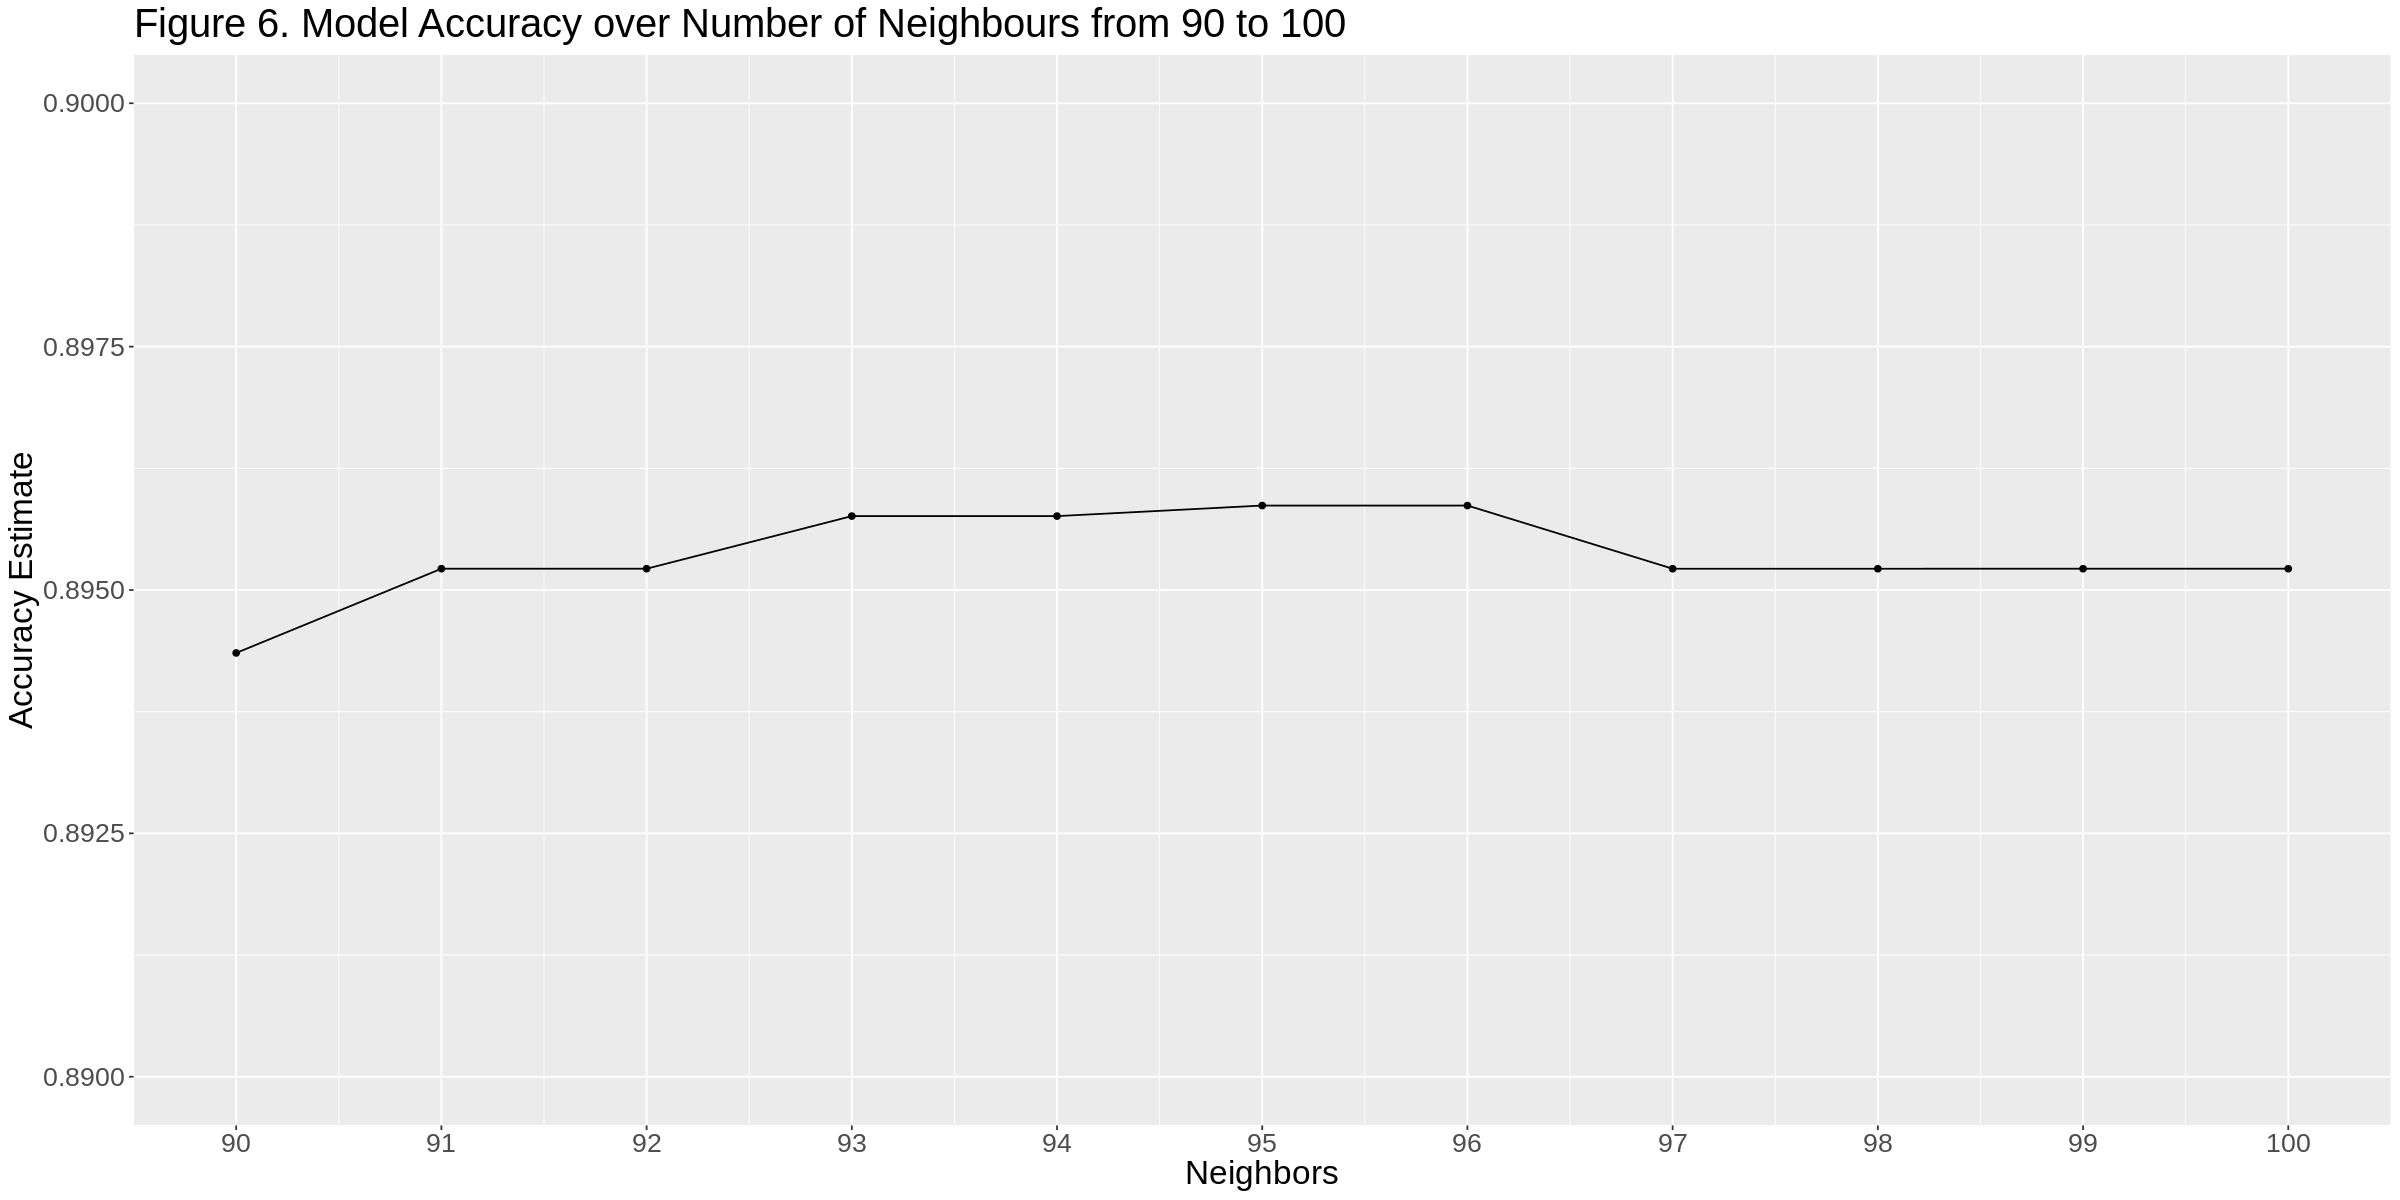

In [20]:
best_accuracies <- tuning_results_best %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))

best_accuracy_versus_k <- ggplot(best_accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure 6. Model Accuracy over Number of Neighbours from 90 to 100") +
    scale_x_continuous(breaks = seq(lower_k, upper_k, by = 1)) +  
    scale_y_continuous(limits = c(0.89, 0.90)) +
    theme(text = element_text(size = 20))
best_accuracy_versus_k

Similar to Figure 5, K-value accuracy was graphed, with very little change in accuracy between these K-values.

In [21]:
# Find the best k
best_k <- tuning_results_best %>% 
            filter(.metric == "accuracy") %>%
            arrange(desc(mean)) %>%
            select(neighbors) %>%
            head(1) %>%
            pull()
best_k

print(paste("Best K-value:", best_k))

[1] 95

[1] "Best K-value: 95"


A new model specification was created with the best K-value found previously. This was then put into a workflow with the same recipe from earlier. The function fit was used to train the model and the best K-value (95) was determined.

In [22]:
# Retrain model
best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

# Combine model in workflow
best_fit <- workflow() %>%
            add_recipe(recipe) %>%
            add_model(best_model) %>%
            fit(data = data_training)

In [23]:
# Make predictions
predictions <- best_fit %>% 
    predict(data_testing) %>% 
    bind_cols(data_testing)

prediction_accuracy <- predictions %>% 
    metrics(truth = Revenue, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")
print("Table 6: Prediction Accuracy for K-nn classification with 95 Neighbours")
prediction_accuracy
print(paste("Prediction accuracy:", prediction_accuracy %>%
            select(.estimate) %>%
            pull)) 

[1] "Table 6: Prediction Accuracy for K-nn classification with 95 Neighbours"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8932511


[1] "Prediction accuracy: 0.893251135626217"


The trained classifier model was then used to make predictions on the testing set using the predict and fit functions. A new column with the classification predictions (revenue = TRUE or FALSE) was created and bound to the data frame with the real labels of revenue from the testing data set. The metrics function gave statistics about the model, specifying which columns indicated true revenue classification and which displayed the model-predicted labels. The estimate variable (Table 6) shows the model’s accuracy when predicting testing set labels.

In [24]:
prediction_matrix <- predictions %>%
    conf_mat(truth = Revenue, estimate = .pred_class)
print("Table 7: Confusion Matrix for K-nn classification with 95 Neighbours")
prediction_matrix

[1] "Table 7: Confusion Matrix for K-nn classification with 95 Neighbours"


          Truth
Prediction FALSE TRUE
     FALSE  2502  226
     TRUE    103  251

The number of correctly and incorrectly predicted revenue labels were displayed in a confusion matrix (Table 7).

## Discussion

This K-nn classification model, using 95 neighbours, correctly predicted the class of an observation in the testing set 89.33% of the time (Table 6). This model only predicted 70.90% of TRUE revenue values in the data set correctly, however only 52.62% of TRUE revenue predictions were correct (Table 7). A vast majority of the FALSE values were predicted correctly.

It was predicted that pages with lower bounce and exit rates and higher page value would be more likely to result in purchases, which reflects the predictions of the model. This also fits with other literature as generally lower bounce and exit rates are often considered positive metrics for page interaction (Zarudnyi, 2018). There was a positive correlation found between page value and revenue, and a negative correlation between bounce and exit rate and revenue.

The data itself was not quite what was expected after researching the predictors used. The maximum bounce and exit rates being 20% (Figure 1, 2), while the average ecommerce bounce rate is between 20-45% (CXL, n.d). This indicates the need to explore why this dataset’s values are lower than average, namely concerning the ecommerce platform used and the dataset’s authors methods of data collection.

A potential issue with this classification model was that there was no clear clustering or separation of the observations with revenue compared to no revenue, as seen in Figures 1-3. This led to worries that this model would predict all values as FALSE (no Revenue) as most of the values (84.5%) were FALSE, and thus ~84.5% accuracy could be achieved by only predicting FALSE. However, the determined accuracy of 89.33% is higher than the proportion of FALSE observations, thus this model must have predicted some values as TRUE. The confusion matrix (Table 7) concurs, with approximately half of predicted TRUE values being correct.

Concerning the impact of these findings, the relatively low accuracy for TRUE revenue predictions might be problematic for any modelling purposes where classifications are needed with a high degree of confidence. However, these lower accuracy scores are not necessarily highly problematic. For instance, models similar to this one could be used to analyze user behaviour and then consequently determine which users have behaviours that might be indicative of TRUE revenue values. Thus, advertising or other methods could be implemented to target these users and increase the chances of revenue.

This model was built with relatively little data compared to the data accessible to larger ecommerce platforms with millions of active users, thus this investigation indicates that it is feasible to create a model that would be useful and potentially profitable in ecommerce. With more advanced classification models possibly accessing a larger variety of data, such as product page durations, and learning from a much larger amount of data, revenue models similar to this one could become much more accurate and play a significant role in the policies and practices of ecommerce companies.

More generally, these revenue models could allow for better understanding of the psychology of online shopping, possibly creating better search algorithms, with personalized promotion of sites with lower bounce and exit rates, which could result in greater e-commerce profits. In addition, figuring out which analytics classify revenue prediction most accurately could lead to companies targeting users who have “ideal analytics” to increase profits further. 

Furthermore, this investigation can lead to further questions, such as whether it is possible to increase revenue by suggesting pages with greater relevance, or if the influence of lower bounce and exit rate can be negated by the use of special sales.

However, there are also questions that are more specific to this model:

How would the chosen K-value change if each K-value in a larger range was tested? Computing power was a limitation for tuning the ideal number of neighbours, hence to investigate general trends in K-values, only periodical values were chosen, with the highest interval being examined more closely. Thus theoretically, the K-value chosen would not necessarily be the highest accuracy for the training set as K-values in other intervals of five could be more accurate. Testing all K-values in a larger range would fix this potential issue and investigate if higher K-values would be more accurate, however this would require either more computing power or longer time periods to run.

What combination of predictors in this dataset would yield the highest accuracy? This could be determined through forward selection, as run below. Due to the ~2 hour computation time, this was not initially run as part of creating the model. As seen in Table 8, the predictor variable combination of  PageValues, BounceRates, Administrative, Informational, and ExitRates gave the highest accuracy. This only increased accuracy slightly compared to the variables used in this model, hence the extra computational time taken to compute this is not worth it for this model. However, this yields further questions, such as why do these predictors yield the highest accuracy? There was no literature found on why these predictors would increase accuracy of this model. Further research on predictor variable selection is needed to answer this, and develop more accurate and complex models in the future.

In [25]:

#Code Source: the following code was taken from Chapter 6 of "Data Science: A First Introduction" by Tiffany-Anne Timbers, Trevor Campbell and Melissa Lee 
# and it was modified to suit this project 

#extract predictor column names 
set.seed(1)
 data <- shopping_data %>% 
 select(-OperatingSystems, -Browser, -VisitorType, -Weekend, -Month)%>%
  mutate(Revenue = as_factor(Revenue))

#get predictor variable names
names <- colnames(data %>% select(-Revenue))


As shown in the cell above, non numeric variables were excluded, as they are less accurate for k-nearest neighbors. 

Forward selection is used below for the predictor selection analysis. It starts with a model having no predictors. Then, it loops through the following 3 tasks until there are no more predictors left to be added: 

    1. adds each unused predictor to the model to form a candidate model
    2. tunes all of the candidate models using 5-fold cross validation
    3. updates the model to be the candidate model with highest 5-fold cross-validation accuracy
    
Then the model that provides a high level of accuracy while still being simple can be selected. 


In [26]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
data_vfold <- vfold_cv(data, v = 5, strata = Revenue)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
# increases over predictor set size
for (i in 1:n_total) {
    
    # for every predictor still not added yet
   
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Revenue", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        recipe <- recipe(as.formula(model_string), data = data) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
 # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = data_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Revenue ~ PageValues,0.8847514
2,Revenue ~ PageValues+BounceRates,0.8898609
3,Revenue ~ PageValues+BounceRates+Administrative,0.8921323
⋮,⋮,⋮
10,Revenue ~ PageValues+BounceRates+Administrative+Informational+ExitRates+ProductRelated_Duration+Informational_Duration+SpecialDay+TrafficType+Administrative_Duration,0.8909964
11,Revenue ~ PageValues+BounceRates+Administrative+Informational+ExitRates+ProductRelated_Duration+Informational_Duration+SpecialDay+TrafficType+Administrative_Duration+Region,0.8898604
12,Revenue ~ PageValues+BounceRates+Administrative+Informational+ExitRates+ProductRelated_Duration+Informational_Duration+SpecialDay+TrafficType+Administrative_Duration+Region+ProductRelated,0.8879143


## References:

CXL. (n.d). Bounce Rate Benchmarks: What’s a Good Bounce Rate, Anyway?. Retrieved from https://cxl.com/guides/bounce-rate/benchmarks/?_ga=2.222008664.1173671750.1628960270-1634105590.1628960270.

Faisal, S., & Tutz, G. (2017, October 3). Nearest Neighbor Imputation for Categorical Data by Weighting of Attributes. ArXiv Statistics. https://arxiv.org/abs/1710.01011.

Google Analytics (2021). Exit Rate vs. Bounce Rate. Retrieved from https://support.google.com/analytics/answer/2525491?hl=en&ref_topic=6156780.

Sakar, C. O., & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Data set]. UCI Machine Learning Repository. Retrieved from https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset.

Zarudnyi, A. (2018, October 26). Understanding and using the bounce rate and exit rate. SE Ranking. Retrieved from https://seranking.com/blog/bounce-rate-vs-exit-rate/.
